In [54]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import YouTubeVideo, display, Image

%matplotlib inline

DATA_RAW_PATH = os.path.abspath(os.path.join(
    os.getcwd(), "../data/raw"))
DATA_OUTPUT_PATH = os.path.abspath(os.path.join(os.getcwd(), "../data/output"))
MODELS_PATH = os.path.abspath(os.path.join(
    os.getcwd(), "../models"))

# To get the example images that below worked on please first run the download_assets.py file

### Highlights

1. Train elsewhere, perform inference in an OpenCV application

2. Supports **Caffe**, **Tensorflow**, **Torch** and **Darknet**.

3. **Supported layers** : AbsVal, AveragePooling, BatchNormalization, Concatenation, Convolution (including dilated convolution), Crop, Deconvolution, DetectionOutput (SSD-specific layer), Dropout, Eltwise (+, *, max), Flatten, FullyConnected, LRN, LSTM, MaxPooling, MaxUnpooling, MVN, NormalizeBBox (SSD-specific layer), Padding, Permute, Power, PReLU (including ChannelPReLU with channel-specific slopes), PriorBox (SSD-specific layer), ReLU, RNN, Scale, Shift, Sigmoid, Slice, Softmax, Split, TanH
4. Use Caffe model trained on the Multi-Person Image Dataset (MPI) to demonstrate human pose estimation for a single person.

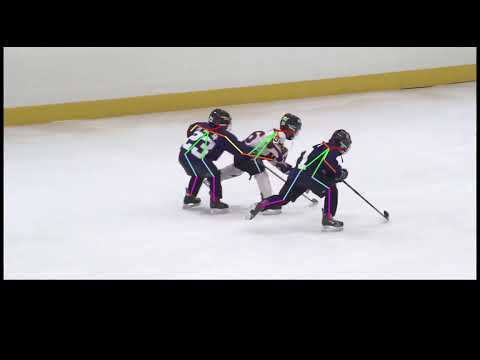

In [55]:
video = YouTubeVideo("RyCsSc_2ZEI", width=1024, height=640)
display(video)

#### Load a Caffe Model
A typical Caffe Model has two files

1. **Architecture** : Defined in a **.prototxt** file
2. **Weights** : Defined in **.caffemodel** file

In [56]:
proto_file = f"{MODELS_PATH}/pose_deploy_linevec_faster_4_stages.prototxt"
weights_file = f"{MODELS_PATH}/model/pose_iter_160000.caffemodel"

nPoints = 15

# links on human anatomy
# 0: head, 1: neck, 2: right shoulder etc.
# model uses this while training
POSE_PAIRS = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [1, 5],
    [5, 6],
    [6, 7],
    [1, 14],
    [14, 8],
    [8, 9],
    [9, 10],
    [14, 11],
    [11, 12],
    [12, 13],
]

net = cv2.dnn.readNetFromCaffe(prototxt=proto_file, caffeModel=weights_file)

In [57]:
img_path = f"{DATA_RAW_PATH}/Tiger_Woods_crop.png"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_width = img.shape[1]
img_height = img.shape[0]

print(img.shape)

(844, 842, 3)


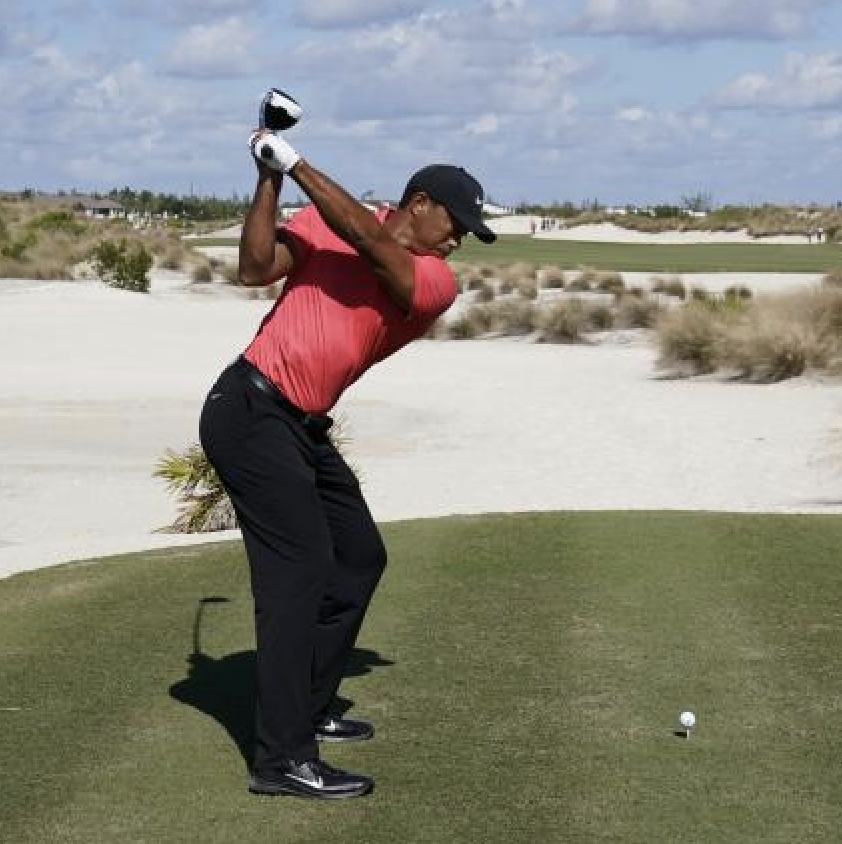

In [58]:
Image(filename=img_path)

#### Convert image to blob

#### What is a “blob”?

A blob in **OpenCV’s DNN module is a 4-dimensional array** that serves as the standard **input format for neural networks**. It wraps the image into a format that the deep neural network expects:


[batch size, number of channels, height, width]

So in this case, the output input_blob is a **NumPy array of shape (1, 3, 368, 368)**:
- 1 image (batch size)
- 3 color channels (RGB or BGR)
- 368 height
- 368 width

```html
cv2.dnn.blobFromImage(
    image,                  # Input image (e.g., from cv2.imread)
    scalefactor=1.0/255,    # Normalize pixel values to [0, 1]
    size=(368, 368),        # Resize to fixed size (expected by the model)
    mean=(0, 0, 0),         # No mean subtraction
    swapRB=True,            # Swap R and B channel (OpenCV uses BGR, models use RGB)
    crop=False              # Don't crop image, just resize
)
```

In [59]:
net_input_size = (368, 368)
input_blob = cv2.dnn.blobFromImage(img, 1.0 / 255, net_input_size, (0, 0, 0), swapRB=True, crop=False)
net.setInput(input_blob)

#### Run Inference (forward pass)

output = net.forward()

output is a 4D tensor with shape:

**(1, nPoints, h_out, w_out)**
Where:
- 1 → batch size
- nPoints → number of keypoints the model predicts (e.g. 18 for body joints like head, elbows, knees, etc.)
- h_out, w_out → the spatial resolution of the output heatmaps (often smaller than the original image, e.g., 46×46)

### What is a probability map (or heatmap)?

Think of each probMap as a grayscale image:
- Each pixel has a value between 0 and 1.
- A value close to 1 means the network is highly confident that the body part (e.g. left elbow) is located at that pixel.
- A value close to 0 means no confidence.

For example: probMap[y][x] = 0.87 means “87% probability that this body part is at pixel (x, y)”.

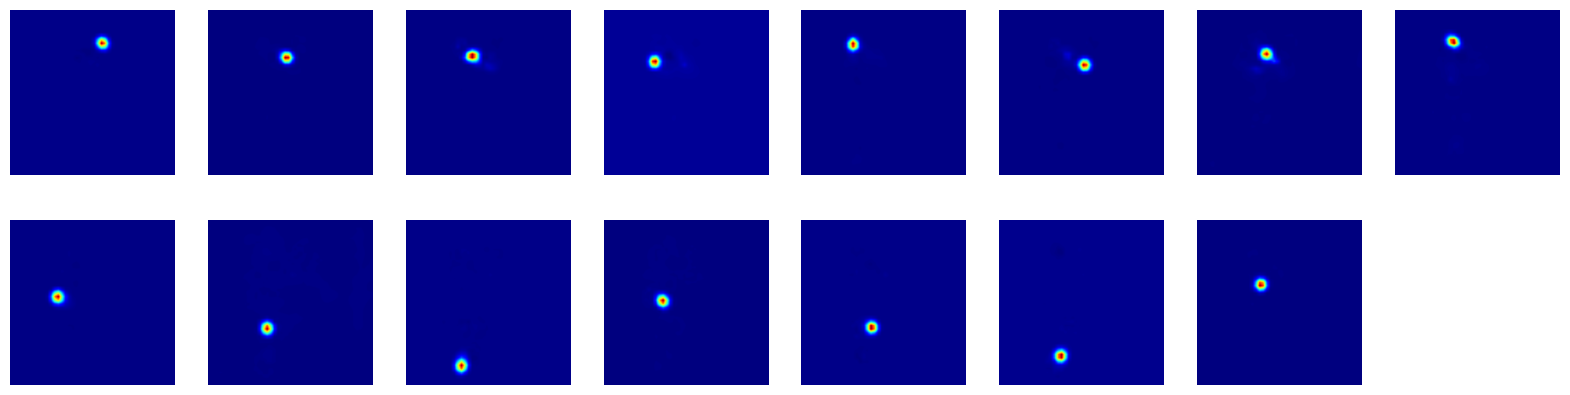

In [60]:
output = net.forward()

# Display probability maps
plt.figure(figsize=[20, 5])

for i in range(nPoints):
    # Obtain probability map
    probMap = output[0, i, :, :]
    # We are taking out the i-th probability map for the i-th keypoint.
	# This is a 2D heatmap (matrix) showing where in the image that body part is likely located.
 
    displayMap = cv2.resize(probMap, (img_width, img_height), cv2.INTER_AREA)
    # The output of the model (probMap) is small (like 46×46 or 64×64).
	# We resize it back to the original image size so it aligns with the real image during visualization.

    plt.subplot(2, 8, i + 1)
    plt.axis("off")
    plt.imshow(displayMap, cmap="jet") # cmap="jet" to colorize the heatmap (blue = low, red/yellow = high values).
    

In [61]:
scaleX = img_width / output.shape[3]
scaleY = img_height / output.shape[2]

# Empty list to store the detected keypoints
points = []

threshold = 0.1

for i in range(nPoints):
    # Obtain probability map
    probMap = output[0, i, :, :]
    
    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to the list if the probability is greater than threshold
    x = scaleX * point[0]
    y = scaleY * point[1]
    
    if prob > threshold:
        points.append((int(x), int(y)))
    else:
        points.append(None)
        



#### Display Points & Skeleton


In [64]:
img_points = img.copy()
img_skeleton = img.copy()

for i, p in enumerate(points):
    cv2.circle(img_points, p, 8, (255, 255, 0), 1, cv2.FILLED)
    cv2.putText(img_points, "{}".format(i), p, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
    
for pair in POSE_PAIRS:
    p1, p2 = pair
    
    if points[p1] and points[p2]:
        cv2.line(img_skeleton, points[p1], points[p2], (255, 255, 0), 2)
        cv2.circle(img_skeleton, points[p1], 8, (255, 0, 0), thickness=-1, lineType=cv2.FILLED)
        cv2.circle(img_skeleton, points[p2], 8, (255, 0, 0), thickness=-1, lineType=cv2.FILLED)
    

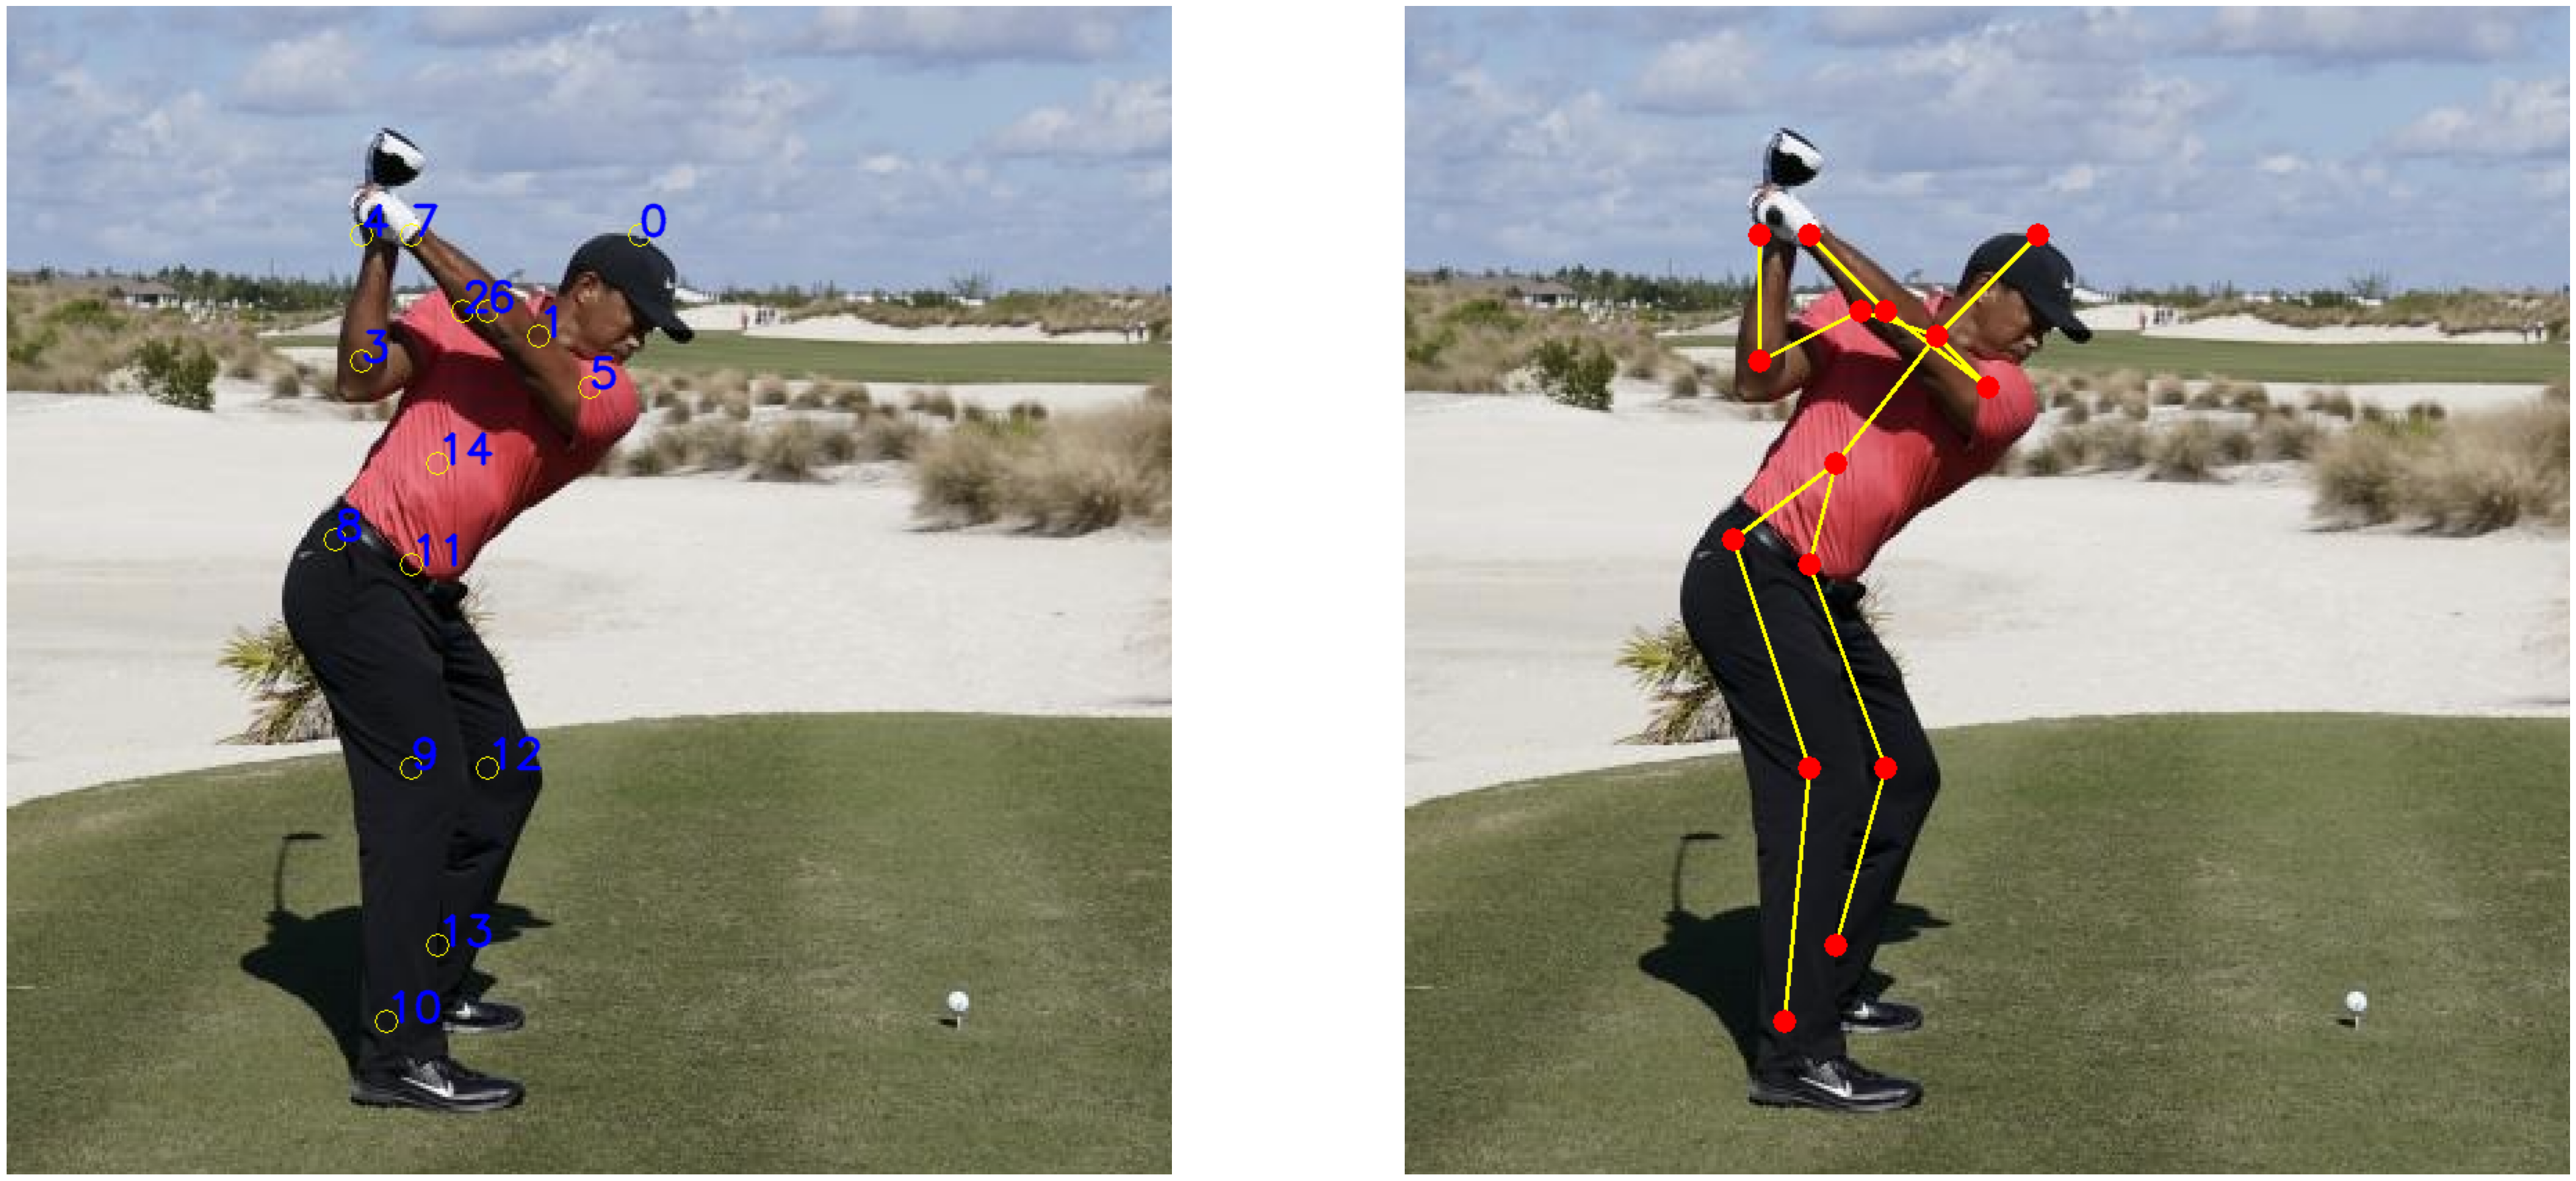

In [65]:
plt.figure(figsize=(50, 50))

plt.subplot(121)
plt.axis("off")
plt.imshow(img_points)

plt.subplot(122)
plt.axis("off")
plt.imshow(img_skeleton)